In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas import datetime
from datetime import timedelta
from pandas.plotting import register_matplotlib_converters

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
register_matplotlib_converters()

from time import time

C:\Users\kerya\AppData\Local\Temp\ipykernel_6112\2449335546.py:4: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


## Import data

The file "valeurs_mensuelles.csv" corresponds to the data here: https://www.insee.fr/fr/statistiques/serie/010537205

In [2]:
data = pd.read_csv("valeurs_mensuelles.csv", sep=";")

In [3]:
data.head()

,Period,IPI,Code
0,2023-02,66.39,A
1,2023-01,72.46,A
2,2022-12,73.16,A
3,2022-11,70.39,A
4,2022-10,68.21,A


In [4]:
data = data.rename(columns={'Period' : 'date', 'IPI' : 'value'})

In [5]:
data.Code.unique()

array(['A'], dtype=object)

In [6]:
data = data.drop(columns = ["Code"])
data["date"] = pd.to_datetime(data["date"])

In [7]:
data = data.set_index("date")

In [8]:
data.head()

,value
date,
2023-02-01,66.39
2023-01-01,72.46
2022-12-01,73.16
2022-11-01,70.39
2022-10-01,68.21


In [9]:
data.shape

(398, 1)

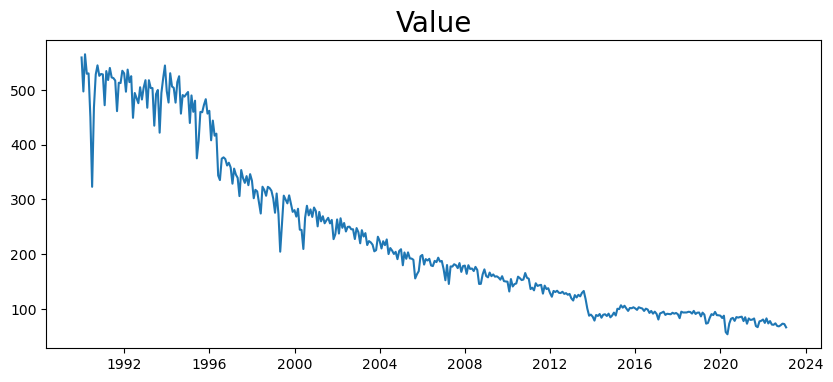

In [10]:
plt.figure(figsize=(10, 4))
plt.plot(data["value"])
plt.title("Value", fontsize=20)
plt.show()

## Stationarisation

In [11]:
def diff(series, order = 1, s=1):
    diffs = series[s:] - series[:-s]
    diffs = np.concatenate([diffs, [0]*s])
    
    if order == 1:
        return diffs
    else:
        return diff(diffs, order - 1, s)

def box_cox(series, alpha=0):
    if alpha == 0:
        return np.log(series)
    elif alpha > 0:
        return (np.power(series, alpha)-1)/alpha
    else:
        raise Exception("alpha must be a positive real.")

In [12]:
for d in range(1, 11):
    data[f"diff_{d}"] = diff(data["value"].values, order=d)

In [13]:
data["log_value"] = box_cox(data["value"])

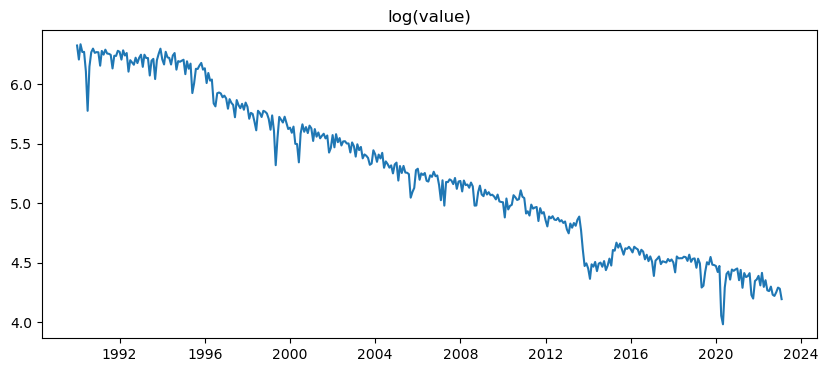

In [14]:
plt.figure(figsize=(10, 4))
plt.plot(data["log_value"])
plt.title("log(value)")
plt.show()

In [15]:
for d in range(1, 11):
    data[f"log_diff_{d}"] = diff(data["log_value"].values, order=d)

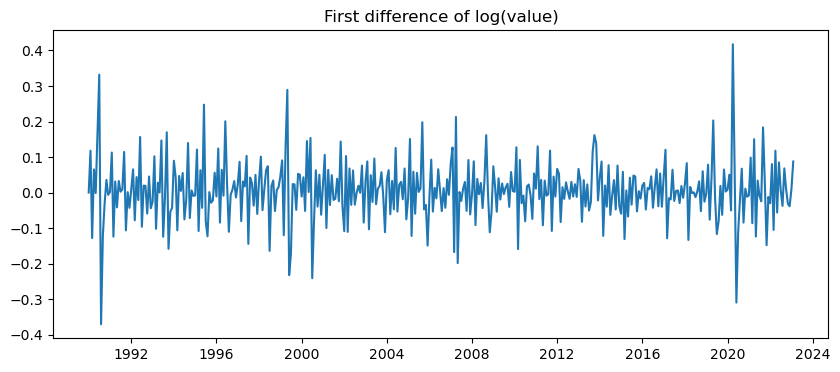

In [16]:
plt.figure(figsize=(10, 4))
plt.plot(data["log_diff_1"])
plt.title("First difference of log(value)")
plt.show()

Evaluating stationarity of variable log_diff_1


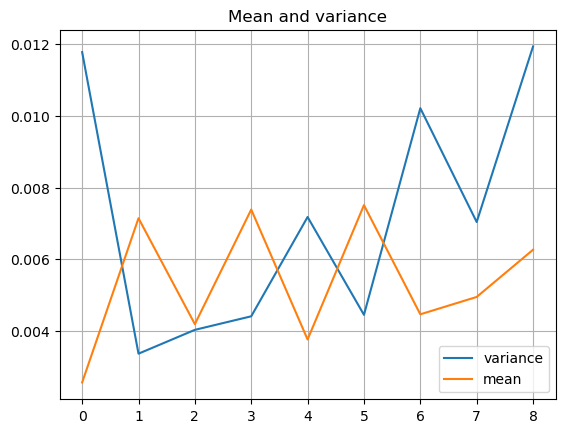

In [17]:
index_list = np.linspace(start=0, stop=data.shape[0], num=10, dtype=int)

def isStationary(variable):
    variances = []
    averages = []
    print("Evaluating stationarity of variable", variable)
    for i in range(len(index_list)-1):
        X = data[variable][index_list[i]:index_list[i+1]]
        variance = X.var()
        average = X.mean()

        variances.append(variance)
        averages.append(average)
    return averages, variances
#     print(f"Data from {index_list[i]} to {index_list[i+1]}: mean = {average}, var = {variance}")


variable = "log_diff_1"
averages, variances = isStationary(variable)
plt.plot(variances, label = "variance")
plt.plot(averages, label = "mean")
plt.legend()
plt.title("Mean and variance")
plt.grid()
plt.show()

Variance appears to be constant. We shall say that this time series is stationary.

In [26]:
result = adfuller(data["log_value"].values)
print("ADF Statistic %f" % result[0])
print("p-value : %f" % result[1])
print("Critical Values:")
for key, value in result[4].items():
    print("\t%s: %.3f" % (key, value))

ADF Statistic -0.222333
p-value : 0.935807
Critical Values:
	1%: -3.447
	5%: -2.869
	10%: -2.571


In [27]:
result = adfuller(data["log_diff_1"].values)
print("ADF Statistic %f" % result[0])
print("p-value : %f" % result[1])
print("Critical Values:")
for key, value in result[4].items():
    print("\t%s: %.3f" % (key, value))

ADF Statistic -7.152133
p-value : 0.000000
Critical Values:
	1%: -3.447
	5%: -2.869
	10%: -2.571


The leading rule is to always use the simplest model. So we're gonna go with log_diff_1.

## Fit ARIMA(p, d, q)

In [34]:
X = data["value"].values
Z = data["log_value"].values

At last, we want to predict X. We know that Z is stationary.

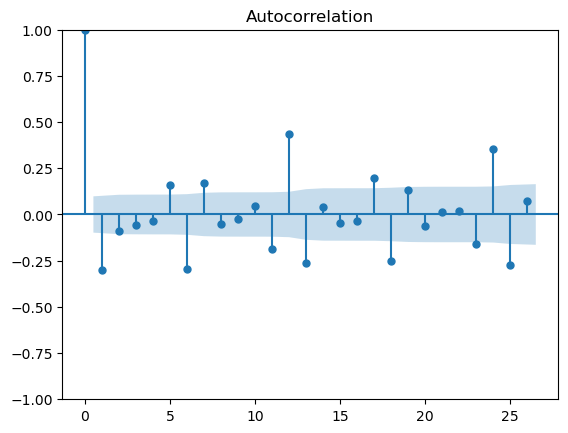

In [36]:
acf_plot = plot_acf(data["log_diff_1"])

We see that autocorrelation is strong for lags 1, 6, 12.

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


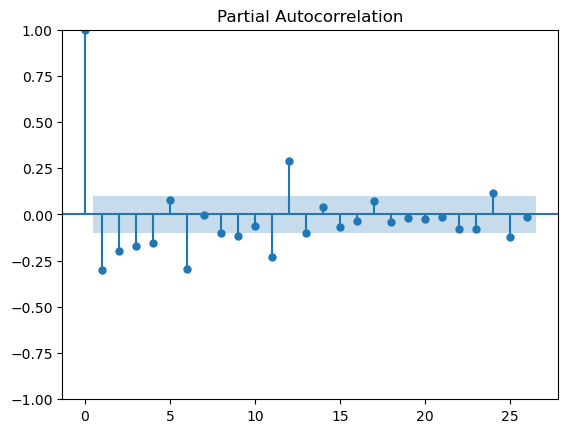

In [37]:
pacf_plot = plot_pacf(data["log_diff_1"])

Based on this partial autocorrelation graph, we will try fitting ARMA(p, q) with p, q in {6, 12} on "log_diff_1", that is, ARIMA(p, 1, q) on Z.

In [43]:
model = ARIMA(Z, order=(6, 1, 6))

In [44]:
model_fit = model.fit()

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [42]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  378
Model:                 ARIMA(6, 1, 6)   Log Likelihood                 502.991
Date:                Thu, 13 Apr 2023   AIC                           -979.983
Time:                        17:13:45   BIC                           -928.863
Sample:                             0   HQIC                          -959.692
                                - 378                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1545      0.134     -1.153      0.249      -0.417       0.108
ar.L2          0.0277      0.152      0.183      0.855      -0.270       0.325
ar.L3          0.1779      0.139      1.276      0.202      -0.095       0.451
ar.L4          0.2665      0.106      2.516      0.012       0.059       0.474
ar.L5          0.3235      0.075      4.338      0.000       0.177       0.470
ar.L6         -0.7034      0.094     -7.478      0.000      -0.888      -0.519
ma.L1         -0.0350      0.144     -0.243      0.808      -0.317       0.247
ma.L2         -0.2321      0.129     -1.801      0.072      -0.485       0.020
ma.L3         -0.2933      0.089     -3.303      0.001      -0.467      -0.119
ma.L4         -0.3102      0.077     -4.050      0.000      -0.460      -0.160
ma.L5         -0.3053      0.089     -3.414      0.001      -0.481      -0.130
ma.L6          0.7590      0.120      6.345      0.000       0.525       0.993
sigma2         0.0040      0.000     18.081      0.000       0.004       0.004
===================================================================================
Ljung-Box (L1) (Q):                   1.44   Jarque-Bera (JB):               619.20
Prob(Q):                              0.23   Prob(JB):                         0.00
Heteroskedasticity (H):               1.00   Skew:                            -0.53
Prob(H) (two-sided):                  0.98   Kurtosis:                         9.19
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [56]:
predictions = model_fit.predict(1, 398)

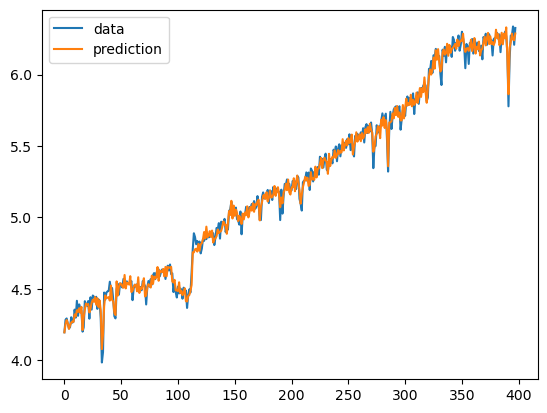

In [61]:
plt.plot(Z, label="Z")
plt.plot(predictions, label="prediction")
plt.legend()
plt.show()

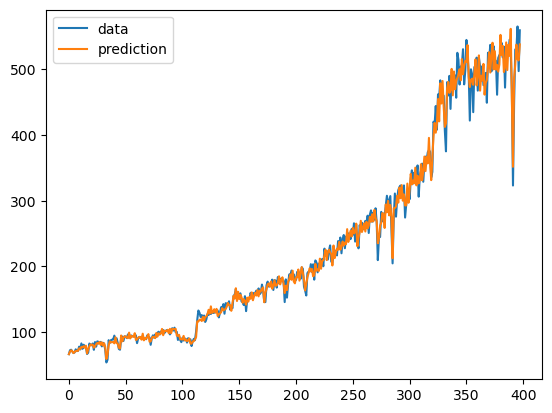

In [63]:
plt.plot(X, label="data")
plt.plot(np.exp(predictions), label="prediction")
plt.legend()
plt.show()

In [67]:
residuals = Z - predictions
#residuals = X - np.exp(predictions) # because X = np.exp(Z)
print("Mean Absolute Percent Error: ", round(np.mean(abs(residuals)), 4))
print("Root mean squared Error: ", round(np.sqrt(np.mean(residuals**2)), 4))

Mean Absolute Percent Error:  0.0416
Root mean squared Error:  0.0491


In [80]:
MAPE = np.zeros((6,6))
RMSE = np.zeros((6,6))
for p in range(1, 7):
    for q in range(1, 7):
        model = ARIMA(Z, order=(p, 1, q))
        model_fit = model.fit()
        predictions = model_fit.predict(1, 398)


    #     plt.plot(X, label="data")
    #     plt.plot(np.exp(predictions), label="prediction")
    #     plt.legend()
    #     plt.title(f"ARIMA({p}, 1 {q})")
    #     plt.show()

        residuals = Z - predictions

        MAPE[p-1, q-1] = round(np.mean(abs(residuals)), 4)
        RMSE[p-1, q-1] = round(np.sqrt(np.mean(residuals**2)), 4)
        #residuals = X - np.exp(predictions) # because X = np.exp(Z)
        print(f"ARIMA({p}, 1, {q})")
        print("Mean Absolute Percent Error: ", round(np.mean(abs(residuals)), 4))
        print("Root mean squared Error: ", round(np.sqrt(np.mean(residuals**2)), 4))
        print("\n")

ARIMA(1, 1, 1)
Mean Absolute Percent Error:  0.0248
Root mean squared Error:  0.0338


ARIMA(1, 1, 2)
Mean Absolute Percent Error:  0.026
Root mean squared Error:  0.0371


ARIMA(1, 1, 3)
Mean Absolute Percent Error:  0.0255
Root mean squared Error:  0.0359


ARIMA(1, 1, 4)
Mean Absolute Percent Error:  0.0244
Root mean squared Error:  0.0331


ARIMA(1, 1, 5)
Mean Absolute Percent Error:  0.0252
Root mean squared Error:  0.0344




C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA(1, 1, 6)
Mean Absolute Percent Error:  0.026
Root mean squared Error:  0.0344


ARIMA(2, 1, 1)
Mean Absolute Percent Error:  0.0248
Root mean squared Error:  0.0338


ARIMA(2, 1, 2)
Mean Absolute Percent Error:  0.0247
Root mean squared Error:  0.0341




C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 1, 3)
Mean Absolute Percent Error:  0.0239
Root mean squared Error:  0.0331




C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 1, 4)
Mean Absolute Percent Error:  0.0371
Root mean squared Error:  0.0449




C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 1, 5)
Mean Absolute Percent Error:  0.0336
Root mean squared Error:  0.0412




C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 1, 6)
Mean Absolute Percent Error:  0.031
Root mean squared Error:  0.0402


ARIMA(3, 1, 1)
Mean Absolute Percent Error:  0.0249
Root mean squared Error:  0.0338




C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(3, 1, 2)
Mean Absolute Percent Error:  0.0258
Root mean squared Error:  0.0348




C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(3, 1, 3)
Mean Absolute Percent Error:  0.0328
Root mean squared Error:  0.039




C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(3, 1, 4)
Mean Absolute Percent Error:  0.0327
Root mean squared Error:  0.0389




C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(3, 1, 5)
Mean Absolute Percent Error:  0.0425
Root mean squared Error:  0.0515




C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(3, 1, 6)
Mean Absolute Percent Error:  0.0351
Root mean squared Error:  0.0432


ARIMA(4, 1, 1)
Mean Absolute Percent Error:  0.0249
Root mean squared Error:  0.0338


ARIMA(4, 1, 2)
Mean Absolute Percent Error:  0.0259
Root mean squared Error:  0.0353




C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(4, 1, 3)
Mean Absolute Percent Error:  0.0354
Root mean squared Error:  0.0429




C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(4, 1, 4)
Mean Absolute Percent Error:  0.04
Root mean squared Error:  0.0468




C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(4, 1, 5)
Mean Absolute Percent Error:  0.041
Root mean squared Error:  0.0492




C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(4, 1, 6)
Mean Absolute Percent Error:  0.0385
Root mean squared Error:  0.0458


ARIMA(5, 1, 1)
Mean Absolute Percent Error:  0.028
Root mean squared Error:  0.0365




C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(5, 1, 2)
Mean Absolute Percent Error:  0.0275
Root mean squared Error:  0.0368




C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(5, 1, 3)
Mean Absolute Percent Error:  0.0397
Root mean squared Error:  0.0472




C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(5, 1, 4)
Mean Absolute Percent Error:  0.0368
Root mean squared Error:  0.0443




C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(5, 1, 5)
Mean Absolute Percent Error:  0.0359
Root mean squared Error:  0.0426




C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(5, 1, 6)
Mean Absolute Percent Error:  0.0369
Root mean squared Error:  0.0445


ARIMA(6, 1, 1)
Mean Absolute Percent Error:  0.0316
Root mean squared Error:  0.0407




C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(6, 1, 2)
Mean Absolute Percent Error:  0.0315
Root mean squared Error:  0.0407




C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(6, 1, 3)
Mean Absolute Percent Error:  0.0338
Root mean squared Error:  0.0413




C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(6, 1, 4)
Mean Absolute Percent Error:  0.0393
Root mean squared Error:  0.047




C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(6, 1, 5)
Mean Absolute Percent Error:  0.0361
Root mean squared Error:  0.044


ARIMA(6, 1, 6)
Mean Absolute Percent Error:  0.0416
Root mean squared Error:  0.0491




C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [114]:
print(MAPE.argmin(), RMSE.argmin(), (MAPE+RMSE).argmin(), (MAPE**2+RMSE**2).argmin())

8 3 8 8


It seems like the best model is the one with 8 = (p-1)*6 + (q-1) -> (p=2, q=3).

Let us fit both ARIMA(6, 1, 6) and ARIMA(2, 1, 3) to see what happen.

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


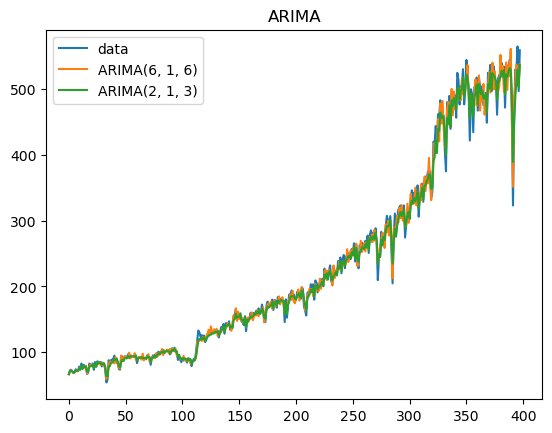

In [116]:
model_6_6 = ARIMA(Z, order=(6, 1, 6))
model_6_6_fit = model_6_6.fit()
predictions_6_6 = model_6_6_fit.predict(1, 398)

model_2_3 = ARIMA(Z, order=(2, 1, 3))
model_2_3_fit = model_2_3.fit()
predictions_2_3 = model_2_3_fit.predict(1, 398)


plt.plot(X, label="data")
plt.plot(np.exp(predictions_6_6), label="ARIMA(6, 1, 6)")
plt.plot(np.exp(predictions_2_3), label="ARIMA(2, 1, 3)")
plt.legend()
plt.title("ARIMA")
plt.show()

As the ARIMA(2, 1, 3) fits well the data, we will keep it.